## 2-数据探索

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

D:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# 定义文件名
ACTION_201602_FILE = "data/JData_Action_201602.csv"
ACTION_201603_FILE = "data/JData_Action_201603.csv"
ACTION_201604_FILE = "data/JData_Action_201604.csv"
COMMENT_FILE = "data/JData_Comment.csv"
PRODUCT_FILE = "data/JData_Product.csv"
USER_FILE = "data/JData_User.csv"

USER_TABLE_FILE = "data/user_table.csv"
ITEM_TABLE_FILE = "data/item_table.csv"

### 周一到周日各天购买情况
不同的时间购买情况不同，我们分析出其中的规律。

比如我们分析出周四、周五的购买量大（京东送货速度快，一般这时候购买周末收货），亦或者周一周二买，上班回来顺便拿，那么即使预测这些时间的购买概率低，我们也可以人为的往上提一点。

In [3]:
# 提取购买(type=4)的行为数据
def get_from_action_data(fname, chunk_size=50000):
    reader = pd.read_csv(fname, header=0, iterator=True)
    chunks = []
    loop = True
    while loop:
        try:
            chunk = reader.get_chunk(chunk_size)[
                ["user_id", "sku_id", "type", "time"]]
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped")
 
    df_ac = pd.concat(chunks, ignore_index=True)
    # type=4,为购买
    df_ac = df_ac[df_ac['type'] == 4]
 
    return df_ac[["user_id", "sku_id", "time"]]

In [4]:
df_ac = []
df_ac.append(get_from_action_data(fname=ACTION_201602_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201603_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201604_FILE))
df_ac = pd.concat(df_ac, ignore_index=True)

Iteration is stopped
Iteration is stopped
Iteration is stopped


In [5]:
print(df_ac.dtypes)

user_id     int64
sku_id      int64
time       object
dtype: object


In [6]:
# 将time字段转换为datetime类型
df_ac['time'] = pd.to_datetime(df_ac['time'])

# 使用lambda匿名函数将时间time转换为星期(周一为1, 周日为７)
df_ac['time'] = df_ac['time'].apply(lambda x: x.weekday() + 1)

In [7]:
df_ac.head()

,user_id,sku_id,time
0,269365,166345,1
1,235443,36692,1
2,247689,9112,1
3,273959,102034,1
4,226791,163550,1


In [11]:
# 周一到周日每天购买用户个数
df_user = df_ac.groupby('time')['user_id'].nunique() # 统计购买的用户，而不是购买量 
df_user = df_user.to_frame().reset_index()
df_user.columns = ['weekday', 'user_num']
df_user

,weekday,user_num
0,1,6162
1,2,6946
2,3,5001
3,4,6409
4,5,6049
5,6,4174
6,7,3710


In [12]:
# 周一到周日每天购买商品个数
df_item = df_ac.groupby('time')['sku_id'].nunique()
df_item = df_item.to_frame().reset_index()
df_item.columns = ['weekday', 'item_num']
df_item

,weekday,item_num
0,1,1844
1,2,1996
2,3,1800
3,4,1805
4,5,1855
5,6,1643
6,7,1578


In [14]:
# 周一到周日每天购买记录个数
df_ui = df_ac.groupby('time', as_index=False).size()
df_ui = df_ui.to_frame().reset_index()
df_ui.columns = ['weekday', 'user_item_num']
df_ui

,weekday,user_item_num
0,1,7759
1,2,8869
2,3,6262
3,4,8078
4,5,7505
5,6,5143
6,7,4636


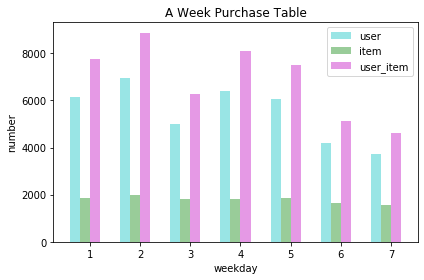

In [15]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4
 
plt.bar(df_user['weekday'], df_user['user_num'], bar_width, alpha=opacity, color='c', label='user')
plt.bar(df_item['weekday']+bar_width, df_item['item_num'], bar_width, alpha=opacity, color='g', label='item')
plt.bar(df_ui['weekday']+bar_width*2, df_ui['user_item_num'], bar_width, alpha=opacity, color='m', label='user_item')
 
plt.xlabel('weekday')
plt.ylabel('number')
plt.title('A Week Purchase Table')
plt.xticks(df_user['weekday'] + bar_width * 3 / 2., (1,2,3,4,5,6,7))
plt.tight_layout() 
plt.legend(prop={'size':10})

user是用户数，item是商品数，user_item是购买记录。

从当前情况看，周二是最高值，周三是最低值。从总体来看工作日的购买情况比周末高。

### 一个月中各天购买量

### 2016年2月

In [16]:
df_ac = get_from_action_data(fname=ACTION_201602_FILE)
 
# 将time字段转换为datetime类型并使用lambda匿名函数将时间time转换为天
df_ac['time'] = pd.to_datetime(df_ac['time']).apply(lambda x: x.day)

Iteration is stopped


In [17]:
df_ac.head()

,user_id,sku_id,time
351,269365,166345,1
649,235443,36692,1
980,247689,9112,1
1719,273959,102034,1
2153,226791,163550,1


In [18]:
df_ac.tail()

,user_id,sku_id,time
11464511,256461,126092,29
11470852,224347,137636,29
11478541,300214,102335,29
11480871,213442,48000,29
11483928,228994,165190,29


In [19]:
# 每天的购买用户、商品、用户购买商品的数量
df_user = df_ac.groupby('time')['user_id'].nunique()
df_user = df_user.to_frame().reset_index()
df_user.columns = ['day', 'user_num']
 
df_item = df_ac.groupby('time')['sku_id'].nunique()
df_item = df_item.to_frame().reset_index()
df_item.columns = ['day', 'item_num']
 
df_ui = df_ac.groupby('time', as_index=False).size()
df_ui = df_ui.to_frame().reset_index()
df_ui.columns = ['day', 'user_item_num']

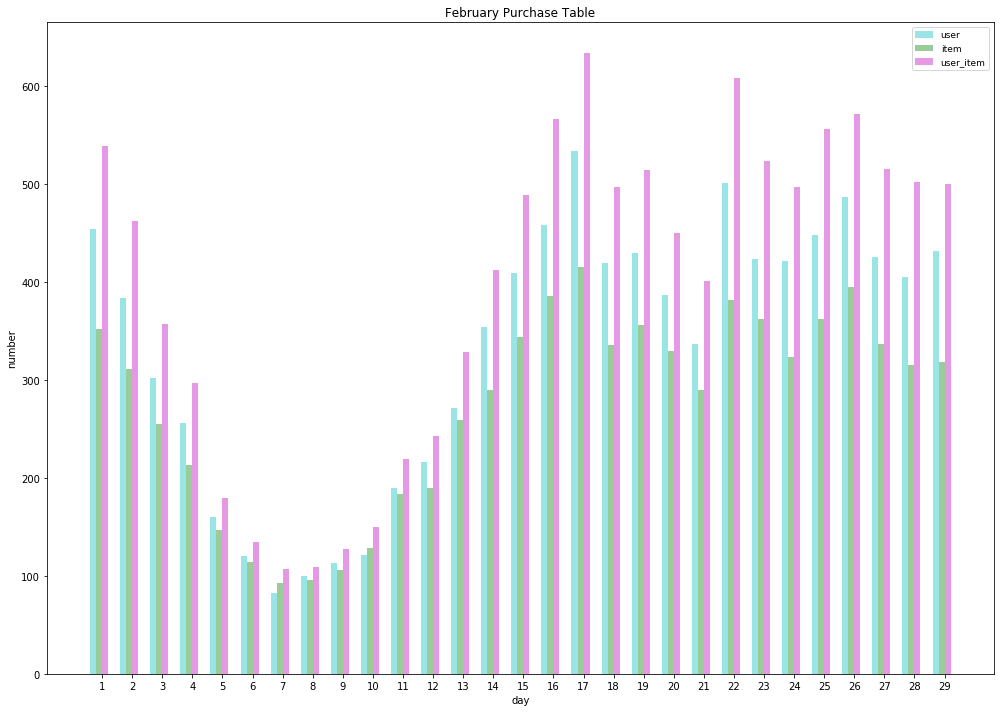

In [20]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4
# 天数
day_range = range(1,len(df_user['day']) + 1, 1)
# 设置图片大小
plt.figure(figsize=(14,10))
 
plt.bar(df_user['day'], df_user['user_num'], bar_width, 
        alpha=opacity, color='c', label='user')
plt.bar(df_item['day']+bar_width, df_item['item_num'], 
        bar_width, alpha=opacity, color='g', label='item')
plt.bar(df_ui['day']+bar_width*2, df_ui['user_item_num'], 
        bar_width, alpha=opacity, color='m', label='user_item')
 
plt.xlabel('day')
plt.ylabel('number')
plt.title('February Purchase Table')
plt.xticks(df_user['day'] + bar_width * 3 / 2., day_range)
# plt.ylim(0, 80)
plt.tight_layout() 
plt.legend(prop={'size':9})

分析： 2月份6~11是开始春节假期,购买量非常少。后续慢慢回稳。

### 2016年3月

In [21]:
df_ac = get_from_action_data(fname=ACTION_201603_FILE)
 
# 将time字段转换为datetime类型并使用lambda匿名函数将时间time转换为天
df_ac['time'] = pd.to_datetime(df_ac['time']).apply(lambda x: x.day)

Iteration is stopped


In [22]:
df_user = df_ac.groupby('time')['user_id'].nunique()
df_user = df_user.to_frame().reset_index()
df_user.columns = ['day', 'user_num']
 
df_item = df_ac.groupby('time')['sku_id'].nunique()
df_item = df_item.to_frame().reset_index()
df_item.columns = ['day', 'item_num']
 
df_ui = df_ac.groupby('time', as_index=False).size()
df_ui = df_ui.to_frame().reset_index()
df_ui.columns = ['day', 'user_item_num']

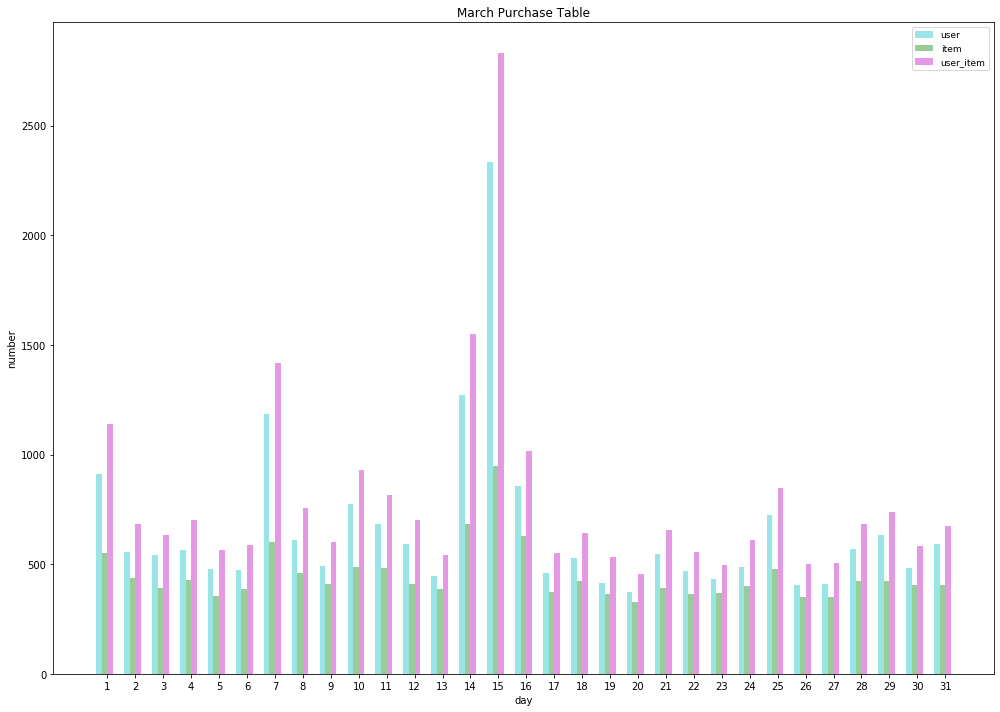

In [23]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4
# 天数
day_range = range(1,len(df_user['day']) + 1, 1)
# 设置图片大小
plt.figure(figsize=(14,10))
 
plt.bar(df_user['day'], df_user['user_num'], bar_width, 
        alpha=opacity, color='c', label='user')
plt.bar(df_item['day']+bar_width, df_item['item_num'], 
        bar_width, alpha=opacity, color='g', label='item')
plt.bar(df_ui['day']+bar_width*2, df_ui['user_item_num'], 
        bar_width, alpha=opacity, color='m', label='user_item')
 
plt.xlabel('day')
plt.ylabel('number')
plt.title('March Purchase Table')
plt.xticks(df_user['day'] + bar_width * 3 / 2., day_range)
# plt.ylim(0, 80)
plt.tight_layout() 
plt.legend(prop={'size':9})

分析：3.15京东营销活动，前后三天的时间购买量激增。

### 2016年4月

In [24]:
df_ac = get_from_action_data(fname=ACTION_201604_FILE)
 
# 将time字段转换为datetime类型并使用lambda匿名函数将时间time转换为天
df_ac['time'] = pd.to_datetime(df_ac['time']).apply(lambda x: x.day)

Iteration is stopped


In [25]:
df_user = df_ac.groupby('time')['user_id'].nunique()
df_user = df_user.to_frame().reset_index()
df_user.columns = ['day', 'user_num']
 
df_item = df_ac.groupby('time')['sku_id'].nunique()
df_item = df_item.to_frame().reset_index()
df_item.columns = ['day', 'item_num']
 
df_ui = df_ac.groupby('time', as_index=False).size()
df_ui = df_ui.to_frame().reset_index()
df_ui.columns = ['day', 'user_item_num']

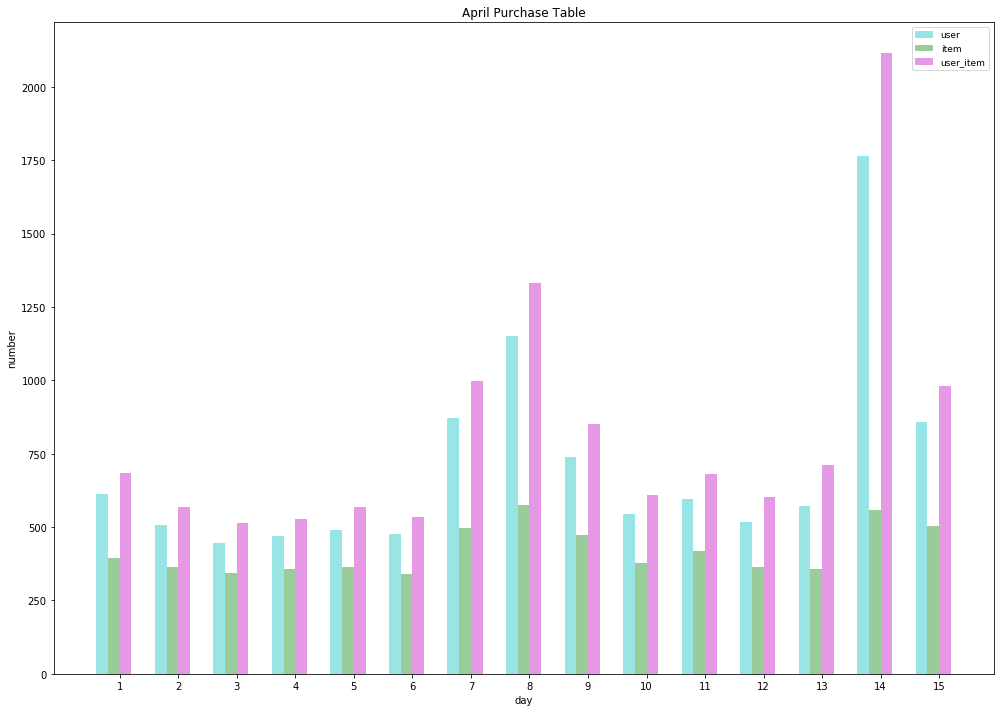

In [26]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4
# 天数
day_range = range(1,len(df_user['day']) + 1, 1)
# 设置图片大小
plt.figure(figsize=(14,10))
 
plt.bar(df_user['day'], df_user['user_num'], bar_width, 
        alpha=opacity, color='c', label='user')
plt.bar(df_item['day']+bar_width, df_item['item_num'], 
        bar_width, alpha=opacity, color='g', label='item')
plt.bar(df_ui['day']+bar_width*2, df_ui['user_item_num'], 
        bar_width, alpha=opacity, color='m', label='user_item')
 
plt.xlabel('day')
plt.ylabel('number')
plt.title('April Purchase Table')
plt.xticks(df_user['day'] + bar_width * 3 / 2., day_range)
# plt.ylim(0, 80)
plt.tight_layout() 
plt.legend(prop={'size':9})

分析：4月份的8号和14号前后销量比较高，可能存在某些活动。

### 商品类别销售统计

### 周一到周日各商品类别销售情况

In [27]:
# 从行为记录中提取商品类别数据
def get_from_action_data(fname, chunk_size=50000):
    reader = pd.read_csv(fname, header=0, iterator=True)
    chunks = []
    loop = True
    while loop:
        try:
            chunk = reader.get_chunk(chunk_size)[
                ["cate", "brand", "type", "time"]]
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped")
 
    df_ac = pd.concat(chunks, ignore_index=True)
    # type=4,为购买
    df_ac = df_ac[df_ac['type'] == 4]
 
    return df_ac[["cate", "brand", "type", "time"]]

In [28]:
df_ac = []
df_ac.append(get_from_action_data(fname=ACTION_201602_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201603_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201604_FILE))
df_ac = pd.concat(df_ac, ignore_index=True)

Iteration is stopped
Iteration is stopped
Iteration is stopped


In [29]:
# 将time字段转换为datetime类型
df_ac['time'] = pd.to_datetime(df_ac['time'])
 
# 使用lambda匿名函数将时间time转换为星期(周一为1, 周日为７)
df_ac['time'] = df_ac['time'].apply(lambda x: x.weekday() + 1)
df_ac.head()

,cate,brand,type,time
0,9,306,4,1
1,4,174,4,1
2,5,78,4,1
3,5,78,4,1
4,4,306,4,1


In [30]:
# 观测有几个类别商品
df_ac.groupby(df_ac['cate']).count()

,cate,brand,type,time
cate,,,,
4,9326,9326,9326,9326
5,8138,8138,8138,8138
6,6982,6982,6982,6982
7,6214,6214,6214,6214
8,13281,13281,13281,13281
9,4104,4104,4104,4104
10,189,189,189,189
11,18,18,18,18


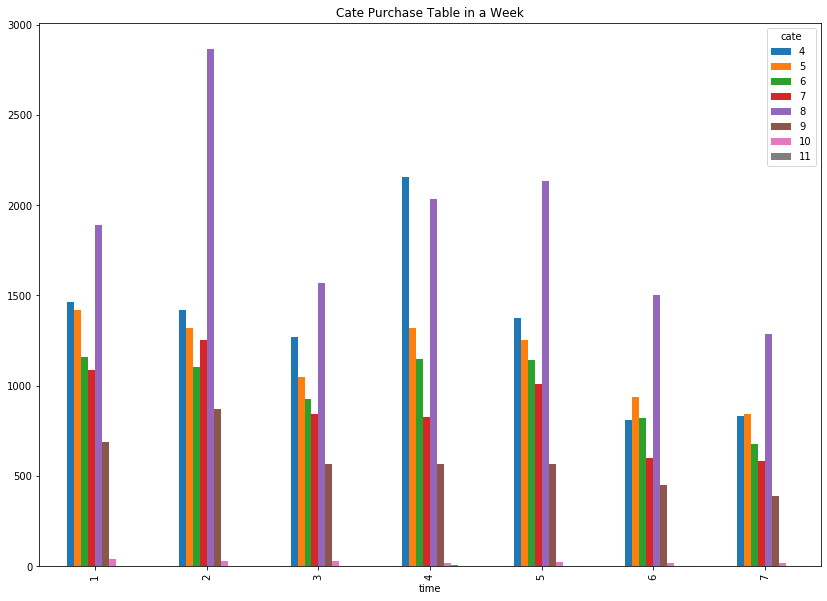

In [31]:
# 周一到周日每天购买商品类别数量统计
df_product = df_ac['brand'].groupby([df_ac['time'],df_ac['cate']]).count()
df_product=df_product.unstack()
df_product.plot(kind='bar',title='Cate Purchase Table in a Week',figsize=(14,10))

分析：星期二买类别8的最多，星期天最少。由上可知，我们需要对商品8做更多的分析。

### 每月各类商品销售情况（只关注商品8）

### 2016年2，3，4月

In [33]:
df_ac2 = get_from_action_data(fname=ACTION_201602_FILE)

# 将time字段转换为datetime类型并使用lambda匿名函数将时间time转换为天
df_ac2['time'] = pd.to_datetime(df_ac2['time']).apply(lambda x: x.day)
 
df_ac3 = get_from_action_data(fname=ACTION_201603_FILE)
df_ac3['time'] = pd.to_datetime(df_ac3['time']).apply(lambda x: x.day)
 
df_ac4 = get_from_action_data(fname=ACTION_201604_FILE)
df_ac4['time'] = pd.to_datetime(df_ac4['time']).apply(lambda x: x.day)

Iteration is stopped
Iteration is stopped
Iteration is stopped


In [34]:
dc_cate2 = df_ac2[df_ac2['cate']==8]
dc_cate2 = dc_cate2['brand'].groupby(dc_cate2['time']).count()
dc_cate2 = dc_cate2.to_frame().reset_index()
dc_cate2.columns = ['day', 'product_num']
 
dc_cate3 = df_ac3[df_ac3['cate']==8]
dc_cate3 = dc_cate3['brand'].groupby(dc_cate3['time']).count()
dc_cate3 = dc_cate3.to_frame().reset_index()
dc_cate3.columns = ['day', 'product_num']
 
dc_cate4 = df_ac4[df_ac4['cate']==8]
dc_cate4 = dc_cate4['brand'].groupby(dc_cate4['time']).count()
dc_cate4 = dc_cate4.to_frame().reset_index()
dc_cate4.columns = ['day', 'product_num']

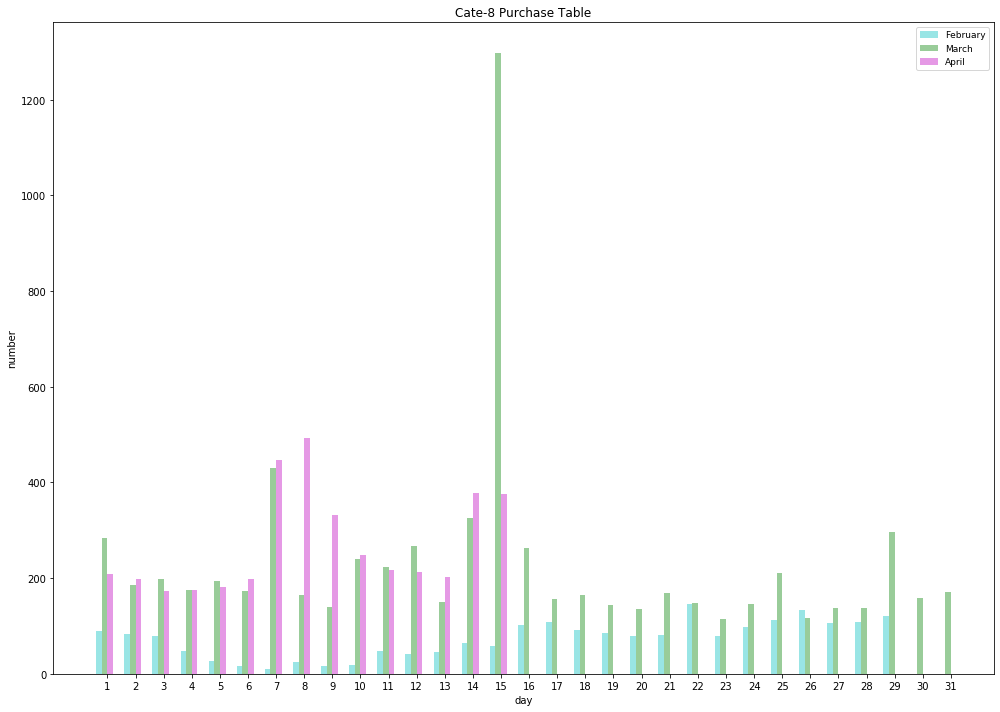

In [35]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4
# 天数
day_range = range(1,len(dc_cate3['day']) + 1, 1)
# 设置图片大小
plt.figure(figsize=(14,10))
 
plt.bar(dc_cate2['day'], dc_cate2['product_num'], bar_width, alpha=opacity, color='c', label='February')
plt.bar(dc_cate3['day']+bar_width, dc_cate3['product_num'], bar_width, alpha=opacity, color='g', label='March')
plt.bar(dc_cate4['day']+bar_width*2, dc_cate4['product_num'], bar_width, alpha=opacity, color='m', label='April')
 
plt.xlabel('day')
plt.ylabel('number')
plt.title('Cate-8 Purchase Table')
plt.xticks(dc_cate3['day'] + bar_width * 3 / 2., day_range)
# plt.ylim(0, 80)
plt.tight_layout() 
plt.legend(prop={'size':9})

分析：2月份对类别8商品的购买普遍偏低，3，4月份普遍偏高，3月15日购买极其多！可以对比3月份的销售记录，发现类别8将近占了3月15日总销售的一半！同时发现，3,4月份类别8销售记录在前半个月特别相似，除了4月8号，9号和3月15号。

### 关于极端值：

类别8的3月15是一个极端值，极端值对于数据建模来说一般是负影响，3月15这天大概率是人为的促进商品8的销售量，而非正常情况，所以我们需要做更多的分析，来确定是否需要保留商品8，或者对3月15号这天的数据做处理。

### 查看特定用户对特定商品的轨迹
如用户对某个商品购买前是先浏览多少次、添加购物车多少次，浏览类似商品等，再进行购买。这样能让模型学到用户怎样的行为会促成购买。

In [36]:
def spec_ui_action_data(fname, user_id, item_id, chunk_size=100000):
    reader = pd.read_csv(fname, header=0, iterator=True)
    chunks = []
    loop = True
    while loop:
        try:
            chunk = reader.get_chunk(chunk_size)[
                ["user_id", "sku_id", "type", "time"]]
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped")

    df_ac = pd.concat(chunks, ignore_index=True)
    df_ac = df_ac[(df_ac['user_id'] == user_id) & (df_ac['sku_id'] == item_id)]

    return df_ac

In [41]:
def explore_user_item_via_time():
    user_id = 266079  # 选择一个用户
    item_id = 138778  # 选择一个item
    df_ac = []
    df_ac.append(spec_ui_action_data(ACTION_201602_FILE, user_id, item_id))
    df_ac.append(spec_ui_action_data(ACTION_201603_FILE, user_id, item_id))
    df_ac.append(spec_ui_action_data(ACTION_201604_FILE, user_id, item_id))

    df_ac = pd.concat(df_ac, ignore_index=False)
    print(df_ac.sort_values(by='time'))

In [42]:
explore_user_item_via_time()  # 看一下该用户对该item的行为轨迹

Iteration is stopped
Iteration is stopped
Iteration is stopped
    user_id  sku_id  type                 time
0    266079  138778     1  2016-01-31 23:59:02
1    266079  138778     6  2016-01-31 23:59:03
15   266079  138778     6  2016-01-31 23:59:40
